In [2]:
import os
import cv2
import glob
import xml.etree.ElementTree as ET
import numpy
import shutil

xml_datoteke = []
mp4_datoteke = []

images_shrani_train = 'data/images/train'
labels_shrani_train = 'data/labels/train'
images_shrani_val = 'data/images/val'
labels_shrani_val = 'data/labels/val'
images_shrani_test = 'data/images/test'
labels_shrani_test = 'data/labels/test'

for file in os.listdir("unprocessed"):
    if file.endswith(".xml"):
        xml_datoteke.append(file)
    elif file.endswith(".mp4"):
        mp4_datoteke.append(file)
xml_datoteke.sort()
mp4_datoteke.sort()

files = glob.glob(f'{images_shrani_train}/*')
for f in files:
    if f.endswith('.png'):
        os.remove(f)
files = glob.glob(f'{labels_shrani_train}/*')
for f in files:
    if f.endswith('.txt'):
        os.remove(f)
files = glob.glob(f'{images_shrani_val}/*')
for f in files:
    if f.endswith('.png'):
        os.remove(f)
files = glob.glob(f'{labels_shrani_val}/*')
for f in files:
    if f.endswith('.txt'):
        os.remove(f)
files = glob.glob(f'{images_shrani_test}/*')
for f in files:
    if f.endswith('.png'):
        os.remove(f)
files = glob.glob(f'{labels_shrani_test}/*')
for f in files:
    if f.endswith('.txt'):
        os.remove(f)

stevilka_slike = 1
frame_video_start = []

for mp4_datoteka in mp4_datoteke:
    frame_video_start.append(stevilka_slike)
    capture = cv2.VideoCapture(os.path.join("unprocessed/", mp4_datoteka))
    while(True):
        success, frame = capture.read()
        if success:
            cv2.imwrite(f'{images_shrani_train}/{stevilka_slike}.png', frame)
            with open(f'{labels_shrani_train}/{stevilka_slike}.txt', 'w') as fp:
                pass
        else:
            break
        stevilka_slike+=1
    capture.release()

for i in range(len(frame_video_start)):
    tree = ET.parse(os.path.join("unprocessed/", xml_datoteke[i]))
    root = tree.getroot()
    image_size = root
    for element in root.iter('original_size'):
        image_size = element
    img_width = int(image_size[0].text)
    img_height = int(image_size[1].text)
    for branch in root:
        if(branch.tag == 'track'):
            for polygon in branch:
                if polygon.attrib['outside'] == '0':
                    #print(polygon.attrib['frame'])
                    if(polygon.tag == 'polygon'):
                        obj_type = branch.attrib['label']
                        obj_blizina = polygon[0].text
                        objekt = f'{obj_type}-{obj_blizina}'
                        objekt_st = 0
                        if(obj_type == 'vozila'):
                            objekt_st+=3
                        elif(obj_type == 'ostalo'):
                            objekt_st+=6
                        if(obj_blizina == 'blizu'):
                            objekt_st+=1
                        elif(obj_blizina == 'dalec'):
                            objekt_st+=2
    
                        polygon_points_str = polygon.attrib['points']
                        points = [tuple(map(float, point.split(','))) for point in polygon_points_str.strip().split(';')]
                        xs = [pt[0] for pt in points]
                        ys = [pt[1] for pt in points]
                        min_x = min(xs)
                        max_x = max(xs)
                        min_y = min(ys)
                        max_y = max(ys)
        
                        obj_class = objekt_st 
                        x_center = (min_x + max_x) / 2.0 / img_width
                        y_center = (min_y + max_y) / 2.0 / img_height
                        obj_width = (max_x - min_x) / img_width
                        obj_height = (max_y - min_y) / img_height
                        frame = int(polygon.attrib['frame']) + frame_video_start[i]
                        with open(f'{labels_shrani_train}/{frame}.txt', "a") as f:
                            f.write(f"{obj_class} {x_center:.6f} {y_center:.6f} {obj_width:.6f} {obj_height:.6f}\n")
                    elif(polygon.tag == 'mask'):
                        obj_type = branch.attrib['label']
                        objekt_st = 0
                        if(obj_type == 'osebe-zelo_blizu'):
                            objekt_st = 0
                        elif(obj_type == 'osebe-blizu'):
                            objekt_st = 1
                        elif(obj_type == 'osebe-daleč'):
                            objekt_st = 2
                        elif(obj_type == 'vozila-zelo_blizu'):
                            objekt_st = 3
                        elif(obj_type == 'vozila-blizu'):
                            objekt_st = 4
                        elif(obj_type == 'vozlia-daleč'):
                            objekt_st = 5
                        elif(obj_type == 'ostalo-zelo_blizu'):
                            objekt_st = 6
                        elif(obj_type == 'ostalo-blizu'):
                            objekt_st = 7
                        elif(obj_type == 'ostalo-daleč'):
                            objekt_st = 8
                        obj_class = objekt_st 
                        x_center = (int(polygon.attrib['left']) + int(polygon.attrib['width']) / 2.0) / img_width
                        y_center = (int(polygon.attrib['top']) + int(polygon.attrib['height']) / 2.0) / img_width
                        obj_width = int(polygon.attrib['width']) / img_width
                        obj_height = int(polygon.attrib['height']) / img_height
                        frame = int(polygon.attrib['frame'])/10 + frame_video_start[i]
                        with open(f'{labels_shrani_train}/{frame}.txt', "a") as f:
                            f.write(f"{obj_class} {x_center:.6f} {y_center:.6f} {obj_width:.6f} {obj_height:.6f}\n")

for i in range(stevilka_slike):
    if i == 0:
        i=1
    zbrisat = False
    with open(f'{labels_shrani_train}/{i}.txt', "r") as f:
        tekst = f.read()
        if(tekst == ""):
            zbrisat = True
    if(zbrisat):
        os.remove(f'{labels_shrani_train}/{i}.txt')
        os.remove(f'{images_shrani_train}/{i}.png')
        zbrisat = False

In [3]:
image_files = sorted(
    [f for f in os.listdir(images_shrani_train) if f.endswith('.png')],
    key=lambda x: int(os.path.splitext(x)[0])
)

for idx, filename in enumerate(image_files):
    file_number = os.path.splitext(filename)[0]
    
    if idx % 7 == 0:
        shutil.move(os.path.join(images_shrani_train, filename), os.path.join(images_shrani_val, filename))
        shutil.move(os.path.join(labels_shrani_train, f'{file_number}.txt'), os.path.join(labels_shrani_val, f'{file_number}.txt'))
    elif idx % 7 == 1:
        shutil.move(os.path.join(images_shrani_train, filename), os.path.join(images_shrani_test, filename))
        shutil.move(os.path.join(labels_shrani_train, f'{file_number}.txt'), os.path.join(labels_shrani_test, f'{file_number}.txt'))

In [4]:
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
import numpy as np
from glob import glob

def transformiraj(image, bboxes=None, class_labels=None):
    transformacija = A.Compose([
        A.HorizontalFlip(p=0.5), #horizontalno zavrti sliko
        A.RandomBrightnessContrast(brightness_limit= 0.4, 
                                   p=0.6), #spremeni svetlino
        A.ColorJitter(p=0.4), #nakljucno spremeni malo vsega
        A.RandomGamma(p=0.3), #spremeni gammo
        A.MotionBlur(p=0.3), #doda blur efekt
        A.RandomShadow(p=0.3), #doda nakljucne sence
        A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-10, 10), p=0.5), #spremeni rotacijo
        A.Resize(height=image.shape[0], width=image.shape[1]), #spremeni velikost
        A.OneOf([
            A.ToGray(p=1.0), #posivi sliko
            A.ChannelDropout(p=1.0) #odstrani kanal
        ], p=0.1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                label_fields=['class_labels'],
                                clip='true',
                                min_visibility=0.1))

    augmented = transformacija(image=image, bboxes=bboxes if bboxes else [], class_labels=class_labels if class_labels else [])
    
    return {
        'image': augmented['image'],
        'bboxes': augmented['bboxes'],
        'class_labels': augmented['class_labels']
    }


def main():
    image_dir = 'data/images/train'
    label_dir = 'data/labels/train'
    output_dir = 'demo_augmentacija'
    os.makedirs(output_dir, exist_ok=True)

    files = glob(f'{output_dir}/*')
    for f in files:
        os.remove(f)
    
    image_paths = glob(os.path.join(image_dir, '*.jpg')) + glob(os.path.join(image_dir, '*.png'))

    for i in range(10):
        img_path = random.choice(image_paths)
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, base_name + '.txt')

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bboxes = []
        class_labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x, y, w, h = map(float, line.strip().split())
                    bboxes.append([x, y, w, h])
                    class_labels.append(int(cls))

        result = transformiraj(image=image, bboxes=bboxes, class_labels=class_labels)
        out_img = cv2.cvtColor(result['image'], cv2.COLOR_RGB2BGR)
        out_img_path = os.path.join(output_dir, f'aug_{i}.png')
        cv2.imwrite(out_img_path, out_img)

        out_label_path = os.path.join(output_dir, f'aug_{i}.txt')
        with open(out_label_path, 'w') as f:
            for bbox, cls in zip(result['bboxes'], result['class_labels']):
                f.write(f"{int(cls)} {' '.join(map(str, bbox))}\n")

    print("konec")
if __name__ == "__main__":
    main()


konec


In [8]:
def transformiraj(image, bboxes=None, class_labels=None):
    transformacija = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.4, p=0.6),
        A.ColorJitter(p=0.4),
        A.RandomGamma(p=0.3),
        A.MotionBlur(p=0.3),
        A.RandomShadow(p=0.3),
        A.Affine(scale=(0.9, 1.1), translate_percent=0.1, rotate=(-10, 10), p=0.5),
        A.Resize(height=image.shape[0], width=image.shape[1]),
        A.OneOf([
            A.ToGray(p=1.0),
            A.ChannelDropout(p=1.0)
        ], p=0.1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                label_fields=['class_labels'],
                                clip=True,
                                min_visibility=0.1))

    augmented = transformacija(image=image, bboxes=bboxes if bboxes else [], class_labels=class_labels if class_labels else [])
    return augmented['image'], augmented['bboxes'], augmented['class_labels']

image_dir = 'data/images/train'
label_dir = 'data/labels/train'

num_augmentations = 2

image_paths = glob(os.path.join(image_dir, '*.png'))
print(f"Najdenih {len(image_paths)} slik v train.")

for img_path in image_paths:
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(label_dir, base_name + '.txt')

    image = cv2.imread(img_path)
    if image is None:
        print(f"Preskakujem nedosegljivo sliko: {img_path}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preberi oznake
    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x, y, w, h = map(float, line.strip().split())
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))
    
    # Izvedi več augmentacij
    for i in range(num_augmentations):
        aug_img, aug_bboxes, aug_classes = transformiraj(image=image, bboxes=bboxes, class_labels=class_labels)

        # Shranimo augmentirano sliko in oznako
        new_name = f"{base_name}_aug_{i}"
        out_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(image_dir, f"{new_name}.png"), out_img)

        with open(os.path.join(label_dir, f"{new_name}.txt"), 'w') as f:
            for bbox, cls in zip(aug_bboxes, aug_classes):
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")

print("Augmentacija zaključena.")

Najdenih 422 slik v train.
Augmentacija zaključena.


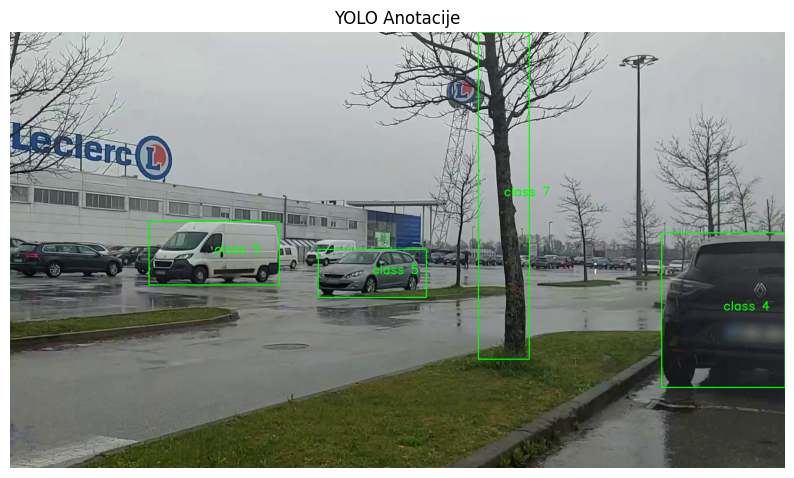

In [7]:
import cv2
import matplotlib.pyplot as plt

frame = 186

image_path = f'data/images/train/{frame}.png'
annotation_path = f'data/labels/train/{frame}.txt'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_h, img_w = image.shape[:2]

with open(annotation_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bbox_w, bbox_h = map(float, parts[1:5])

    x_min = int((x_center - bbox_w / 2) * img_w)
    x_max = int((x_center + bbox_w / 2) * img_w)
    y_min = int((y_center - bbox_h / 2) * img_h)
    y_max = int((y_center + bbox_h / 2) * img_h)
    x_cent = img_w*x_center
    y_cent = img_h*y_center

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    cv2.putText(image, f'class {class_id}', (int(x_cent), int(y_cent)),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.title("YOLO Anotacije")
plt.show()


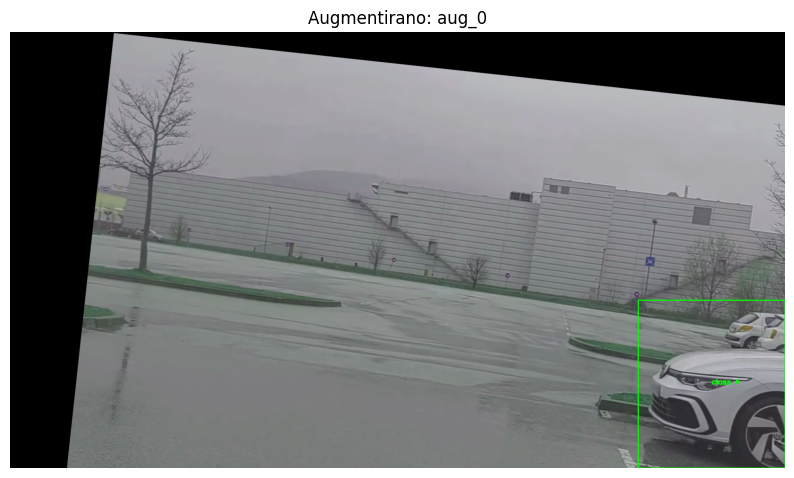

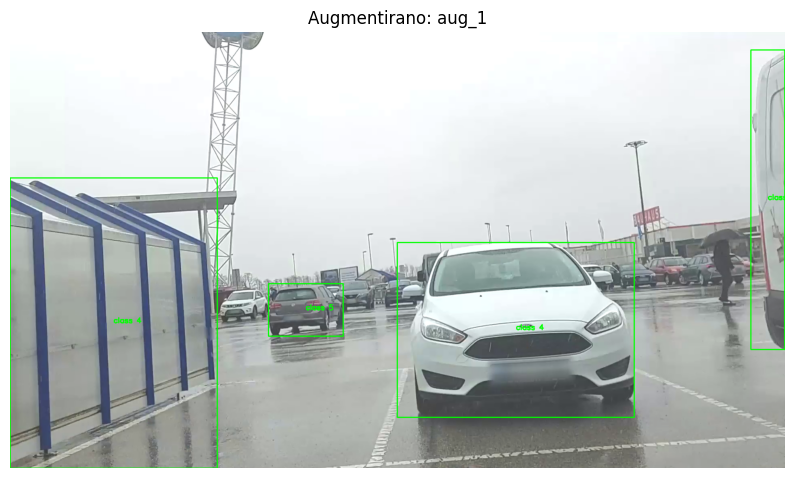

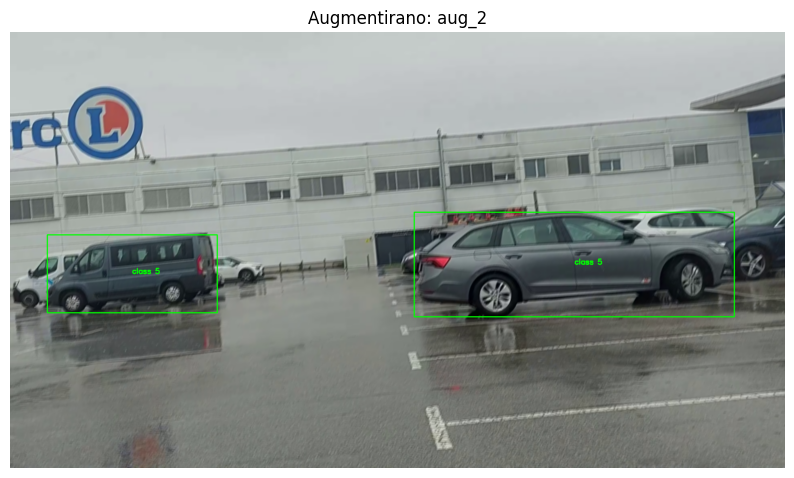

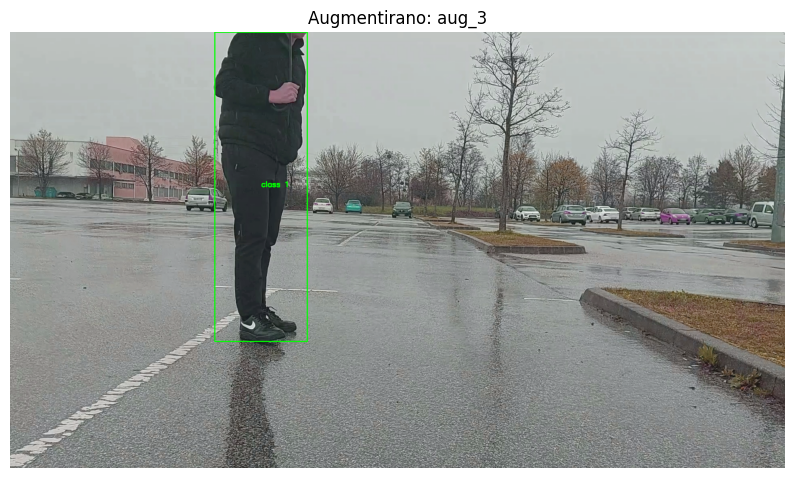

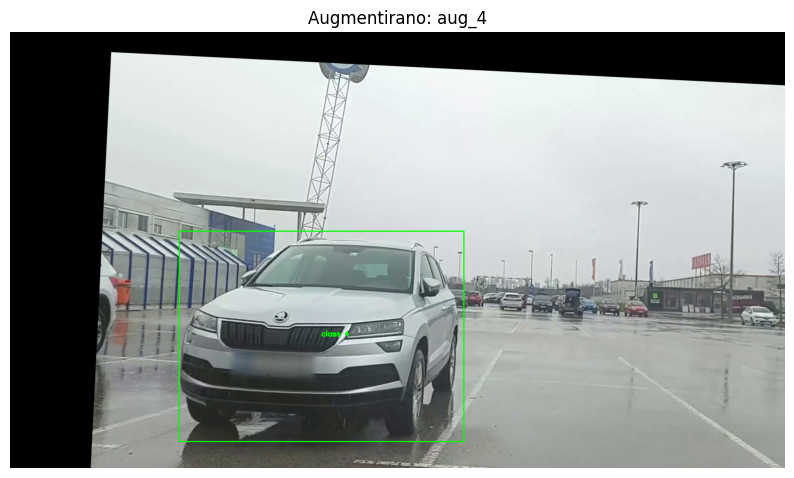

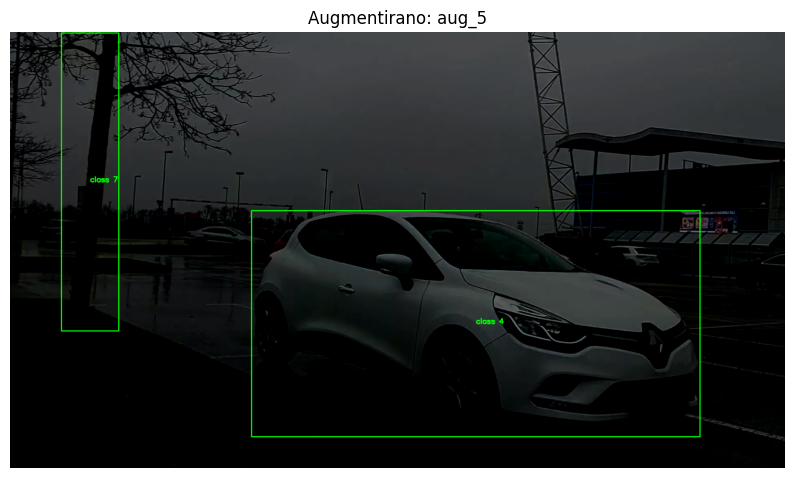

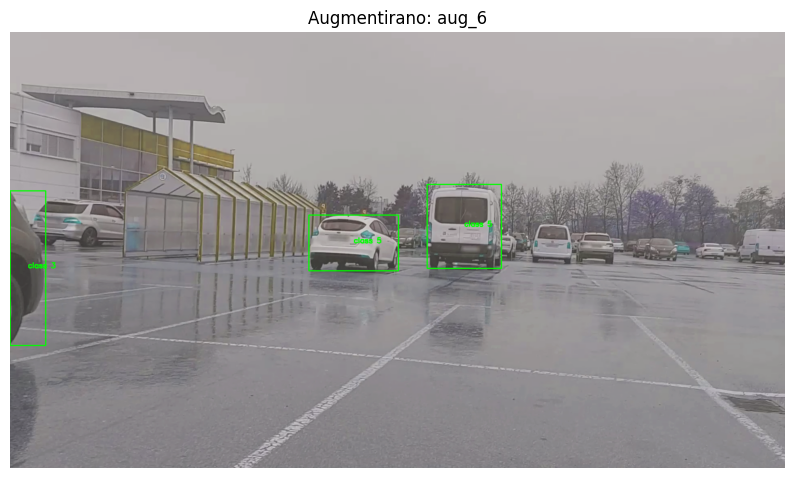

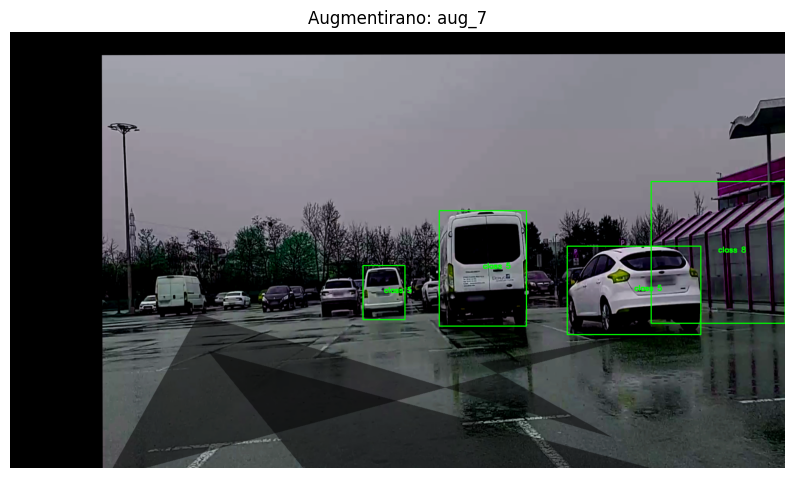

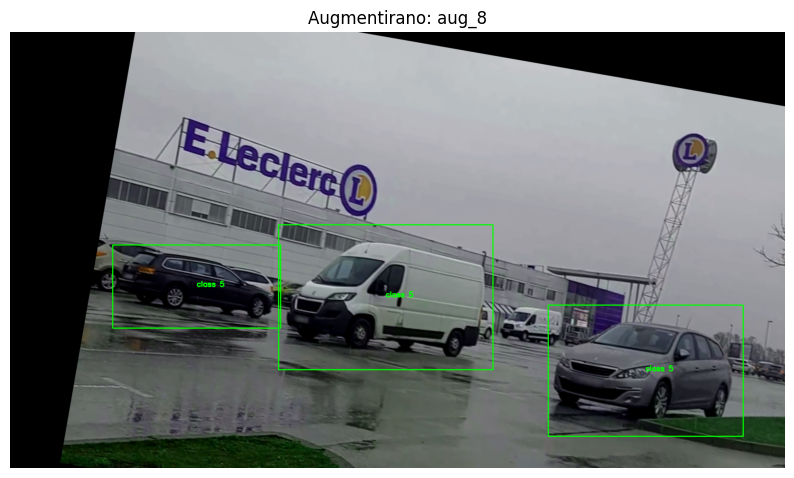

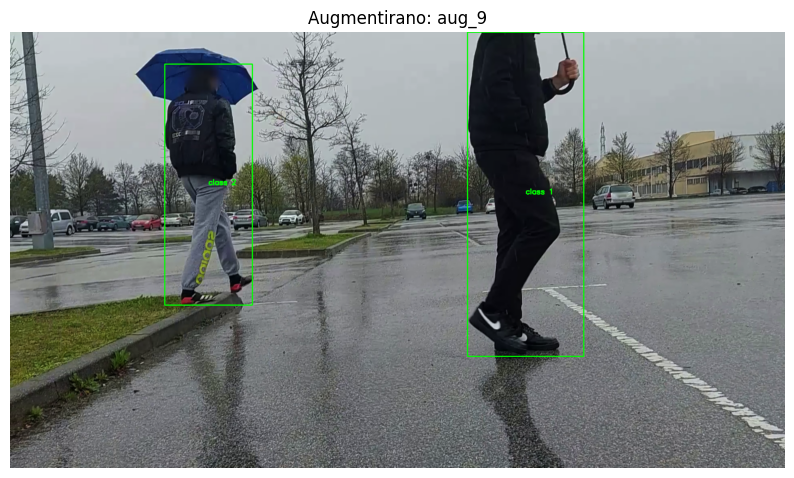

In [20]:
import cv2
import matplotlib.pyplot as plt
import os
import glob

def prikazi_anotacije(image, label_path):
    img_h, img_w = image.shape[:2]

    with open(label_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        class_id = int(parts[0])
        x_center, y_center, bbox_w, bbox_h = map(float, parts[1:])

        x_min = int((x_center - bbox_w / 2) * img_w)
        x_max = int((x_center + bbox_w / 2) * img_w)
        y_min = int((y_center - bbox_h / 2) * img_h)
        y_max = int((y_center + bbox_h / 2) * img_h)

        x_cent = int(x_center * img_w)
        y_cent = int(y_center * img_h)

        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
        cv2.putText(image, f'class {class_id}', (x_cent, y_cent),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return image

demo_dir = 'demo_augmentacija'
image_paths = sorted(glob.glob(os.path.join(demo_dir, 'aug_*.png')))

for img_path in image_paths:
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(demo_dir, base_name + '.txt')

    image = cv2.imread(img_path)
    if image is None or not os.path.exists(label_path):
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = prikazi_anotacije(image, label_path)

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Augmentirano: {base_name}")
    plt.show()
